# Social Graphs and Interaction 2018
## Assignment 2 - Tweeter

In [334]:
# imports
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import matplotlib.image as mpimg
import nltk
import io
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Part 1: Twitter Network Analysis

### _Exercise_ 1: Build the network of retweets.
We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweets. You can build the network following the steps below (and you should  be able to reuse many of the functions you wrote in previous weeks):

* Consider the 200 most recent tweets written by each member of the house (use the files [here](https://github.com/suneman/socialgraphs2018/tree/master/files/data_twitter/tweets.zip), or the ones you produced in Part 1). For each file, use a regular expression to find retweets and to extract the Twitter handle of the user whose content was retweeted. All retweets begin with "_RT @originalAuthor:_", where "_originalAuthor_" is the handle of the user whose content was retweeted (and the part of the text you want to extract).
* For each retweet, check if the handle retweeted is the one of a member of the house. If yes, keep it. If no, discard it.
* Use a NetworkX [`DiGraph`](https://networkx.github.io/documentation/development/reference/classes.digraph.html) to store the network. Use weighted edges to account for multiple retweets. Store also the party of each member as a node attribute (use the data in [this file](https://github.com/suneman/socialgraphs2018/blob/master/files/data_twitter/H115_tw.csv), or the data you downloaded in Part 1). Remove self-loops (edges that connect a node with itself).



In [200]:
### Read Data from twitter files into DiGraph###

# File in socialgraphs2018/files/data_twitter/H115_tw.csv
df = pd.read_csv('../../socialgraphs2018/files/data_twitter/H115_tw.csv')

# Creating DiGraph and saving content
contents = {}
DiG = nx.DiGraph()

# Add nodes with attribute 'Party'
for tw_name in df['tw_name']:
    DiG.add_node(tw_name, Party=df[df.tw_name==tw_name]['Party'].values[0])

# Add edges/retweets and save content
pattern = 'RT @\w+'
for tw_name in df['tw_name']:
    # Open file and read tweets
    f = open("../../socialgraphs2018/files/data_twitter/tweets/"+tw_name, "r")
    content = f.read()
    
    # Find retweets
    rts_raw = re.findall(pattern, content)
    rts = []
    # Extract tweeter handlers
    for i in range(len(rts_raw)):
        rt = rts_raw[i].replace("RT @", "")
        # Check if tweeter handler a member of the house and is not a self-loop
        if rt in df['tw_name'].values and rt != tw_name:
            rts.append(rt)
            # update weight or add new edge
            if DiG.has_edge(tw_name, rt):
                DiG[tw_name][rt]['weight']+=1
            else:
                DiG.add_edge(tw_name,rt,weight=1)
    
    # save data
    contents[tw_name] = {'name': tw_name,
                         'tweets': content, 
                         'Party': df[df.tw_name==tw_name]['Party'].values[0], 
                         'rt':rts}    

 ### _Exercise_ 2: Visualize the network of retweets and investigate differences between the parties.
 * Visualize the network using the [Networkx draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and nodes coordinates from the force atlas algorithm (see Week 5, Exercise 2). _Hint: use the undirected version of the graph to find the nodes positions for better results, but stick to the directed version for all measurements._ Plot nodes in colors according to their party (e.g. 'red' for republicans and 'blue' for democrats) and set the nodes' size proportional to their total degree. 
  * Compare the network of Retweets with the network of Wikipedia pages (Week 5, exercise 2). Do you observe any difference? How do you explain them?

In [201]:
# Set layout
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1,

                          # Performance
                          jitterTolerance=0.01,  #1 # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.02, #0.01
                          strongGravityMode=True, #False
                          gravity=0.15, #15

                          # Log
                          verbose=True)

# Make undirected graph
G = DiG.to_undirected()

# Calculate Positions
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=4000)

100%|██████████| 4000/4000 [00:14<00:00, 272.02it/s]

BarnesHut Approximation  took  4.42  seconds
Repulsion forces  took  8.23  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.18  seconds
AdjustSpeedAndApplyForces step  took  0.84  seconds


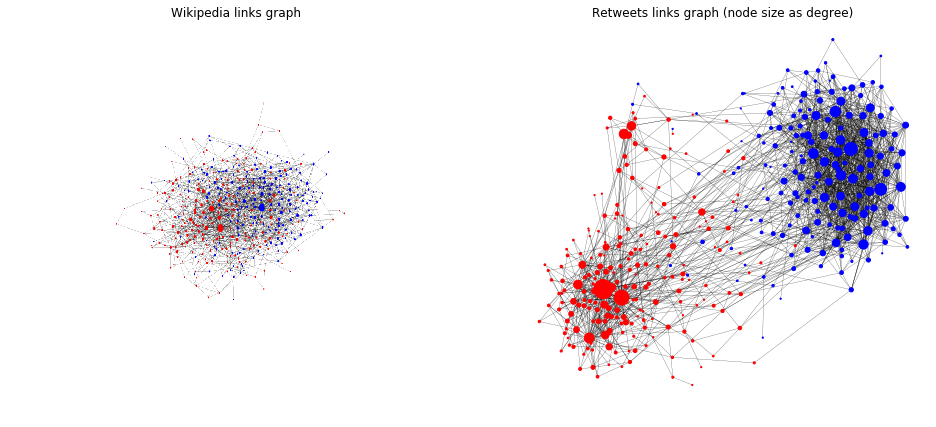

In [190]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

#Wikipedia
img=mpimg.imread('wikiNetwork.png')
imgplot = axs[0].imshow(img, interpolation='nearest', aspect='auto')
axs[0].axis('off')
axs[0].set_title("Wikipedia links graph")

# Divide Democratics and Republicans
Democratics = [key for key, value in contents.items() if value['Party'] == 'Democratic']
Republicans = [key for key, value in contents.items() if value['Party'] == 'Republican'] 

# Calculate size of nodes
node_size_democratics = [DiG.degree(member, weight='weight')*1.5 for member in Democratics]
node_size_republicans = [DiG.degree(member, weight='weight')*1.5 for member in Republicans]

# Add nodes and edges
nx.draw_networkx_nodes(G, positions, nodelist=Democratics, node_color='blue', node_size=node_size_democratics,cmap=plt.get_cmap('jet'), ax=axs[1])
nx.draw_networkx_nodes(G, positions, nodelist=Republicans, node_color='red', node_size=node_size_republicans,cmap=plt.get_cmap('jet'), ax=axs[1])
nx.draw_networkx_edges(G, positions, width=0.2, cmap=plt.get_cmap('jet'), ax=axs[1])
axs[1].set_title('Retweets links graph (node size as degree)')
ax=axs[1].axis('off')
plt.show()

* Now set the nodes' size proportional to their betweenness centrality. What do you observe?
* Repeat the point above using eigenvector centrality instead. Is there any difference? Can you explain why?

/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


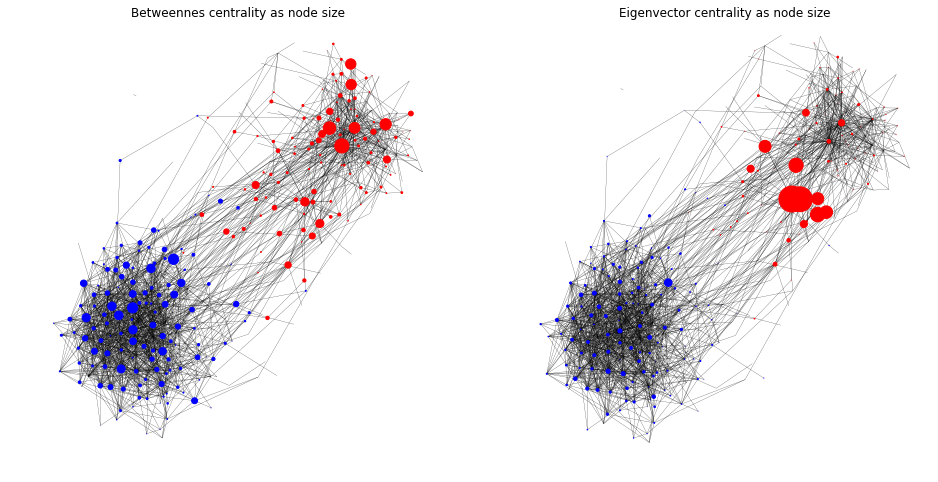

In [218]:
# Making plots
fig, axs = plt.subplots(1,2, figsize=(16,8))

# Function dividing into parties and calculating size
def nodeSize(centralityDict, Republicans, Democratics, n):
    republicans = []
    democratics = []
    for k,v in centralityDict.items():
        if k in Republicans:
            republicans.append(v*n)
        elif k in Democratics:
            democratics.append(v*n)
        else:
            print(k+" is missing")
    return republicans, democratics
    
# Calculate betweenness centrality and find node size
betweenness_centrality = nx.betweenness_centrality(DiG, weight='weight')
betweenness_node_size_republicans, betweenness_node_size_democratics = nodeSize(
    betweenness_centrality, Republicans, Democratics, 2000)

# Calculate eigenvector centrality and find node size
eigenvector_centrality = nx.eigenvector_centrality_numpy(DiG, weight='weight')
eigenvector_node_size_republicans, eigenvector_node_size_democratics = nodeSize(
    eigenvector_centrality, Republicans, Democratics, 1000)

# Add nodes and edges for betweenness centrality
nx.draw_networkx_nodes(G, positions, nodelist=Democratics, node_color='blue', node_size=betweenness_node_size_democratics,cmap=plt.get_cmap('jet'), ax=axs[0])
nx.draw_networkx_nodes(G, positions, nodelist=Republicans, node_color='red', node_size=betweenness_node_size_republicans,cmap=plt.get_cmap('jet'), ax=axs[0])
nx.draw_networkx_edges(G, positions, width=0.2, cmap=plt.get_cmap('jet'), ax=axs[0])
axs[0].set_title("Betweennes centrality as node size")
axs[0].axis('off')

# Add nodes and edges for eigenvector centrality
nx.draw_networkx_nodes(G, positions, nodelist=Democratics, node_color='blue', node_size=eigenvector_node_size_democratics,cmap=plt.get_cmap('jet'), ax=axs[1])
nx.draw_networkx_nodes(G, positions, nodelist=Republicans, node_color='red', node_size=eigenvector_node_size_republicans,cmap=plt.get_cmap('jet'), ax=axs[1])
nx.draw_networkx_edges(G, positions, width=0.2, cmap=plt.get_cmap('jet'), ax=axs[1])
axs[1].set_title("Eigenvector centrality as node size")
axs[1].axis('off')

# Show plots
plt.show()

* Who are the three nodes with highest degree within each party? And eigenvector centrality? And betweenness centrality?

In [192]:
# Function calculating nodes with highest xx from the two parties
def highetFromParties(sortedDict, maximum):
    democratic = [] 
    republican = []
    for k,v in sortedDict.items():
        if k in Republicans and len(republican)<maximum:
            republican.append(k+" "+str(v))
        elif k in Democratics and len(democratic)<maximum:
            democratic.append(k+" "+str(v))
        elif len(republican)>maximum and len(democratic)>maximum:
            break
    return democratic, republican 

# Nodes with highest degree
degree_sorted = dict(sorted(DiG.degree(weight='weight'), key=lambda x: x[1], reverse=True))
democratic_degree, republican_degree = highetFromParties(degree_sorted,3)

# Nodes with highest eigenvector centrality
eigenvector_centrality_sorted = dict(sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True))
democratic_eigen, republican_eigen = highetFromParties(eigenvector_centrality_sorted, 3)

# Nodes with highest betweenness centrality
betweenness_centrality_sorted = dict(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True))
democratic_between, republican_between = highetFromParties(betweenness_centrality_sorted,3)

# Printing result
print("Highest degree among Republicans:")
[print("- "+republican) for republican in republican_degree]
print()
print("Highest eigenvector centrality among Republicans:")
[print("- "+republican) for republican in republican_eigen]
print()
print("Highest betweenness centrality among Republicans:")
[print("- "+republican) for republican in republican_between]
print()

print("Highest degree among Democratics:")
[print("- "+democratic) for democratic in democratic_degree]
print()
print("Highest eigenvector centrality among Democratics:")
[print("- "+democratic) for democratic in democratic_eigen]
print()
print("Highest betweenness centrality among Democratics:")
[print("- "+democratic) for democratic in democratic_between]


Highest degree among Republicans:
- SpeakerRyan 242
- SteveScalise 148
- GOPLeader 64

Highest eigenvector centrality among Republicans:
- RepMarkMeadows 0.672565594979
- Jim_Jordan 0.617666838134
- CongressmanHice 0.208612948702

Highest betweenness centrality among Republicans:
- SpeakerRyan 0.10111175888518115
- PatrickMcHenry 0.07872883100037975
- GOPLeader 0.06326473255177802

Highest degree among Democratics:
- NancyPelosi 111
- repmarkpocan 90
- WhipHoyer 73

Highest eigenvector centrality among Democratics:
- JoaquinCastrotx 0.0569346907405
- repmarkpocan 0.0180442998067
- NancyPelosi 0.0175078955689

Highest betweenness centrality among Democratics:
- RepDavidEPrice 0.05344895403008066
- WhipHoyer 0.052135089171562274
- RepSarbanes 0.03618033588718225


[None, None, None]

* Plot on the same figure the distribution of outgoing strength for the republican and democratic nodes (e.g. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?

In [193]:
# Calculate out degree for republicans
republican_out = []
for republican in Republicans:
    republican_out.append(DiG.out_degree(republican, weight='weight'))

# Calculate out degree for democratics
democratic_out = []
for democratic in Democratics:
    democratic_out.append(DiG.out_degree(democratic, weight='weight'))

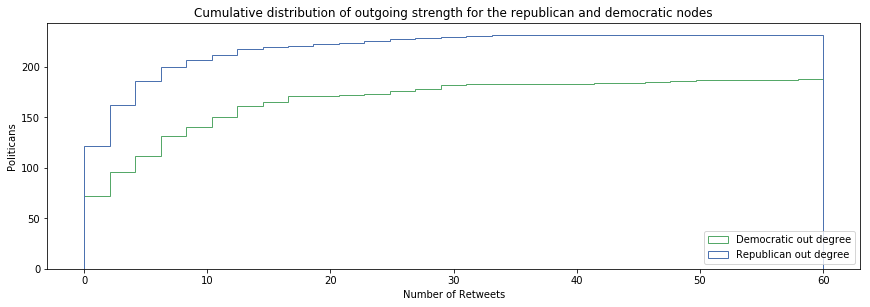

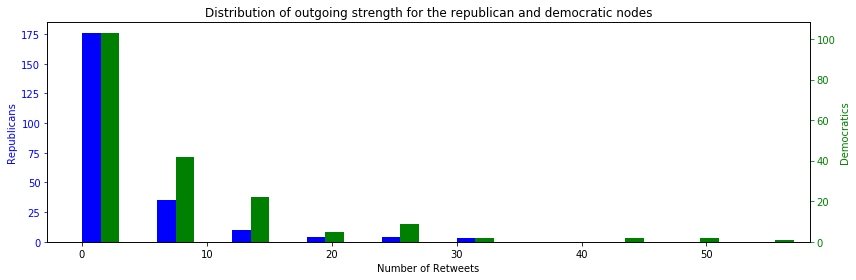

In [194]:
# Create Cumulative Step Histogram 
plt.figure(figsize=(12, 4))  
plt.style.use('seaborn-deep')
bins = np.linspace(0, np.max([np.max(republican_out), np.max(democratic_out)]), 30)

plt.hist([republican_out, democratic_out], 
         bins, 
         label=['Republican out degree', 'Democratic out degree'], 
         histtype='step', 
         cumulative=True)

plt.legend(loc='lower right')
plt.tight_layout()
plt.title("Cumulative distribution of outgoing strength for the republican and democratic nodes")
plt.ylabel("Politicans")
plt.xlabel("Number of Retweets")
plt.show()

# Create two sided bar Histogram 
colors = ['b','g']
#sets up the axis and gets histogram data
fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()
ax1.hist([republican_out, democratic_out], color=colors)
n, bins, patches = ax1.hist([republican_out, democratic_out])
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * 0.25
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Republicans", color=colors[0])
ax2.set_ylabel("Democratics", color=colors[1])
ax1.set_xlabel("Number of Retweets")
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
plt.title("Distribution of outgoing strength for the republican and democratic nodes")
plt.tight_layout()
plt.show()

In [195]:
# Printing Statistics
print('{:>20} {:>20} {:>20} {:>20} {:>20}'
      .format(
          "Party",
          "Max retweets", 
          "sum of all retweets",
          "average retweet per member",
          "Number of members"))

print('{:>20} {:>20} {:>20} {:>20} {:>20}'
      .format("Republicans:", 
              np.max(republican_out), 
              sum(republican_out), 
              str(sum(republican_out)/len(Republicans)),
             len(Republicans)))
      
print('{:>20} {:>20} {:>20} {:>20} {:>20}'
      .format("Democratics:", 
              np.max(democratic_out), 
              sum(democratic_out), 
              str(sum(democratic_out)/len(Democratics)),
             len(Democratics)))

               Party         Max retweets  sum of all retweets average retweet per member    Number of members
        Republicans:                   35                 1014    4.370689655172414                  232
        Democratics:                   60                 1467    7.803191489361702                  188


* Find the 3 members of the republican party that have retweet more often tweets from democratic members. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house?

In [196]:
# Function finding cross retweets
def CrossRetweets (party):
    CrossRetweet = {}
    for member in party:   
        for rt in contents[member]['rt']:
            if contents[rt]['Party'] != contents[member]['Party']:
                if member in CrossRetweet:
                    CrossRetweet[member]+=1  
                else:
                   CrossRetweet[member]=1
    return CrossRetweet

# Find cross retweets and sort them according to number of retweets
sortedCrossR = sorted(CrossRetweets(Republicans).items(), key=lambda item: (item[1], item[0]), reverse=True)
sortedCrossD = sorted(CrossRetweets(Democratics).items(), key=lambda item: (item[1], item[0]), reverse=True)

# Display
print ("The three Democrats Congress Members retweeting Republicans the most often are:")
[print("- "+str(sortedCrossD[i][0])+" -> "+str(sortedCrossD[i][1])+" times") for i in range(3)]
print()

print ("The three Republicans Congress Members retweeting Democrats the most often are:")
[print("- "+str(sortedCrossR[i][0])+" -> "+str(sortedCrossR[i][1])+" times") for i in range(3)]

The three Democrats Congress Members retweeting Republicans the most often are:
- RepDebDingell -> 3 times
- RepAnnaEshoo -> 3 times
- jahimes -> 2 times

The three Republicans Congress Members retweeting Democrats the most often are:
- RepRyanCostello -> 5 times
- RepMikeTurner -> 5 times
- CongressmanGT -> 5 times


[None, None, None]

### _Exercise_ 3: Community detection.

* Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network? Comment on your result.
* Visualize the network, using the Force Atlas algorithm (see Lecture 5, exercise 2). This time assign each node a different color based on their _community_. Describe the structure you observe.
* Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). 
*  [Plot the confusion matrix](https://scipython.com/book/chapter-7-matplotlib/examples/visualizing-a-matrix-with-imshow/) and explain how well the communities you've detected correspond to the parties. Consider the following questions:
  * Are there any republicans grouped with democrats (and vice versa)?
  * Does the community detection algorithm sub-divide the parties? Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.

# Part 2: What do republican and democratic members tweet about?

### _Exercise_ 4: TF-IDF of the republican and democratic tweets.

We will create two documents, one containing the words extracted from tweets of republican members, and the other for Democratic members. We will then use TF-IDF to compare the content of these two documents and create a word-cloud. The procedure you should use is exactly the same you used in exercise 2 of week 7. The main steps are summarized below: 
* Create two large documents, one for the democratic and one for the republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party. 
  * Exclude all twitter handles.
  * Exclude punctuation.
  * Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).
  * Exclude numbers (since they're difficult to interpret in the word cloud).
  * Set everything to lower case.
  * Compute the TF-IDF for each document.
* Now, create word-cloud for each party. Are these topics less "boring" than the wikipedia topics from a few weeks ago? Why?  Comment on the results.

# Part 3: Sentiment analysis

### _Exercise_ 5: Sentiment over the Twitter data.

* Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.


In [242]:
names=["word", "happiness_rank","happiness_average", "happiness_standard_deviation", 
       "twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]

dsS1 = pd.read_csv('journal.pone.0026752.s001.TXT', header=None, delimiter="\t", names=names, skiprows=[0,1,2,3])
dsS1.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


* Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).

In [ ]:
# tokens is a list of tokens
# ds is the data set S1 as a dataframe
def calculates_sentiment(tokens, ds):
    if len(tokens)==0:
        return 0
    
    keys = [key.lower() for key in tokens if key.lower() in ds['word'].values]
    normalization = len(keys)
    if normalization==0:
        return 0
    
    sums = sum(ds.loc[ds['word'] == key]['happiness_average'].values[0] for key in keys)
    return sums/normalization

calculates_sentiment(['love','happy'], dsS1)

* Create two lists: one including the tweets written by democratic members, and the other including the tweets written by republican members (in the text files, tweets are separated by newlines). 

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
stopwordslist = set(stopwords.words('english'))
democratic_tweets = []
republican_tweets = []
twitterTags = ['rm', 'rt']

for key in contents:
    if key in Democratics:
        for row in contents[key]['tweets'].split('\n'):
            string = row
            w = re.findall(r'@\w*', string)
            for i in range(0, len(w)):
                string = string.replace(w[i], "")
            w = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+[\/\w+]*', string)
            for i in range(0, len(w)):
                string = string.replace(w[i], "")
            string = re.sub(r'\d+', '', string)
            string = string.lower()
            filtered = tokenizer.tokenize(string)
            filtered = [w for w in filtered if w not in stopwordslist and w not in twitterTags]
            democratic_tweets.append(filtered)
            print(filtered)
            print('o')
            
print(democratic_tweets[0])               

* Calculate the sentiment of each tweet and plot the distribution of sentiment for each of the two lists. Are there significant differences between the two? Which party post more positive tweets?

* Compute the average _m_ and standard deviation $\sigma$  of the tweets sentiment (considering tweets by both republican and democrats). 

* Now consider only tweets with sentiment lower than m-2$\sigma$. We will refer to them as _negative_ tweets.  Build a list containing the _negative_ tweets written by democrats, and one for republicans. Compute the TF-IDF for these two lists (use the same pre-processing steps in Exercise 5). Create a word-cloud for each of them. Comment on the differences between the _negative_ contents posted by republicans and democrats.

* Repeat the point above, but considering _positive_ tweets instead (e.g. with sentiment larger than m+2$\sigma$). Comment on your results.